# Machine Learning for predict GT1 substrates

# 1、load data

In [10]:
import pandas as pd
import numpy as np
%matplotlib inline
import random
from os.path import join
import os
import re
import sys
import time
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from Bio import SeqIO
import warnings
import torch
warnings.filterwarnings("ignore")

CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)

/home/hcyao/Pycharm/GT1-ML


In [11]:
# 导入yang的数据进行机器学习模型构建
df=pd.read_pickle("./data/GT1/GT1_df_maccs.pkl")

In [12]:
df.activity.value_counts()

0.0    2335
1.0     512
Name: activity, dtype: int64

### 1.1 external test  ECFP4 、MACCS and JTVAE

### ECFP4

In [13]:
df_Berry=pd.read_pickle("./data/GT1/GT1_Berry_df.pkl")
df_Oat=pd.read_pickle("./data/GT1/GT1_Oat_df.pkl")
# X、y in dataset
def create_input_and_output_data(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b_ts"][ind]
        ecfp = np.array(list(df["ECFP_1024"][ind])).astype(int)
                
        X = X +(np.concatenate([ecfp, emb]), );
        y = y + (df["activity"][ind], );

    return(X,y)

X_Berry, y_Berry =  create_input_and_output_data(df_Berry)
X_Oat, y_Oat =  create_input_and_output_data(df_Oat)
X_Berry=np.array(X_Berry)
y_Berry=np.array(y_Berry)
X_Oat=np.array(X_Oat)
y_Oat=np.array(y_Oat)

In [16]:
pd.Series(y_Berry).value_counts()

0    261
1    119
dtype: int64

In [17]:
pd.Series(y_Oat).value_counts()

0    185
1     81
dtype: int64

###  save external test set as npy

In [ ]:
np.save("./data/splits/X_Berry.npy",X_Berry)
np.save("./data/splits/X_Oat.npy",X_Oat)
np.save("./data/splits/y_Berry.npy",y_Berry)
np.save("./data/splits/y_Oat.npy",y_Oat)

### JTVAE

In [2]:
df_Berry=pd.read_pickle("./data/GT1/GT1_Berry_jtvae.pkl")
df_Oat=pd.read_pickle("./data/GT1/GT1_Oat_jtvae.pkl")
# X、y in dataset
def create_input_and_output_data(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b_ts"][ind]
        jtvae = df["jt-vae"][ind]
                
        X = X +(np.concatenate([jtvae, emb]), );
        y = y + (df["activity"][ind], );

    return(X,y)

X_Berry, y_Berry =  create_input_and_output_data(df_Berry)
X_Oat, y_Oat =  create_input_and_output_data(df_Oat)
X_Berry=np.array(X_Berry)
y_Berry=np.array(y_Berry)
X_Oat=np.array(X_Oat)
y_Oat=np.array(y_Oat)

In [9]:
len(df_Berry['ESM1b_ts'][1])

1280

In [6]:
len(df_Berry['jt-vae'][1])

28

In [ ]:
np.save("./data/splits/jtvae/X_Berry.npy",X_Berry)
np.save("./data/splits/jtvae/X_Oat.npy",X_Oat)
np.save("./data/splits/jtvae/y_Berry.npy",y_Berry)
np.save("./data/splits/jtvae/y_Oat.npy",y_Oat)

## MACCS

In [7]:
df_Berry=pd.read_pickle("./data/GT1/GT1_Berry_df.pkl")
df_Oat=pd.read_pickle("./data/GT1/GT1_Oat_df.pkl")
# X、y in dataset
def create_input_and_output_data(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b_ts"][ind]
        ecfp = np.array(list(df["MACCS"][ind])).astype(int)
                
        X = X +(np.concatenate([ecfp, emb]), );
        y = y + (df["activity"][ind], );

    return(X,y)

X_Berry, y_Berry =  create_input_and_output_data(df_Berry)
X_Oat, y_Oat =  create_input_and_output_data(df_Oat)
X_Berry=np.array(X_Berry)
y_Berry=np.array(y_Berry)
X_Oat=np.array(X_Oat)
y_Oat=np.array(y_Oat)

In [ ]:
np.save("./data/splits/maccs/X_Berry.npy",X_Berry)
np.save("./data/splits/maccs/X_Oat.npy",X_Oat)
np.save("./data/splits/maccs/y_Berry.npy",y_Berry)
np.save("./data/splits/maccs/y_Oat.npy",y_Oat)

# 2、ECFP4、oversampling method(for imbalanced data) 

In [12]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score,matthews_corrcoef,precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [13]:
len(np.concatenate([np.array(list(df['ECFP_1024'][0])).astype(int),df["ESM1b_ts"][0]],))

2304

In [14]:
len(df['activity'])

2847

In [15]:
# X=df[['ECFP_1024',"ESM1b_ts"]]
# y=df['activity']

In [16]:
# X、y in dataset
def create_input_and_output_data_ecfp(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b_ts"][ind]
        ecfp = np.array(list(df["ECFP_1024"][ind])).astype(int)
                
        X = X +(np.concatenate([ecfp, emb]), );
        y = y + (df["activity"][ind], );

    return(X,y)

X, y =  create_input_and_output_data_ecfp(df )
X=np.array(X)
y=np.array(y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 888)
#helper function to apply resampling
def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    if type(X) is np.ndarray and type(y) is np.ndarray:
        X_resampled,y_resampled = transformer.fit_resample(X,y)
    elif type(X) is pd.DataFrame and type(y) is pd.Series:
        X_resampled,y_resampled = transformer.fit_resample(X.values,y.values.ravel())
    else:
        print('X,y are neither ndarray nor dataframe or not the same type')
        raise
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

#transform dataset
datasets = []
datasets.append(("Original",X_train,y_train))
methods = ['RandomOverSampler','SMOTE','BorderlineSMOTE','SVMSMOTE','ADASYN','SMOTEENN','SMOTETomek']
for m in methods:
    apply_method = 'datasets.append(transform({}(random_state = 42),X_train,y_train))'.format(m)
    eval(apply_method)
    
#calculate the performance of each sampling method
resample_scores = []
for sampling_type,X,y in datasets:
    print("Training on {}".format(sampling_type))
    rf = RandomForestClassifier(n_jobs = -1, random_state = 42,n_estimators = 160)
    rf.fit(X,y)
    pred_test = rf.predict(X_test)
    pred_test_probs = rf.predict_proba(X_test)
#    probs = rf.decision_function(X_test.values) #be used with linear regression.
    fpr, tpr, thresholds = roc_curve(y_test,pred_test)
#    p,r,t = precision_recall_curve(y_test.values.ravel(),probs)
    resample_scores.append((sampling_type,
                   f1_score(y_test,pred_test),
                   precision_score(y_test,pred_test),
                   recall_score(y_test,pred_test),
                   accuracy_score(y_test,pred_test),
                   auc(fpr, tpr),
                   matthews_corrcoef(y_test,pred_test),
#                   auc(p,r,reorder=True),
                   confusion_matrix(y_test,pred_test)))

#print results
sampling_results = pd.DataFrame(resample_scores, columns=['Sampling Type','F1','precision','recall',
                                                 'accuracy','ROC_AUC','MCC','confusion_matrix'])
#sampling_results.rename(columns=str.upper,inplace = True)
sampling_results.round(2)

Transforming RandomOverSampler
Transforming SMOTE
Transforming BorderlineSMOTE
Transforming SVMSMOTE
Transforming ADASYN
Transforming SMOTEENN
Transforming SMOTETomek
Training on Original
Training on RandomOverSampler
Training on SMOTE
Training on BorderlineSMOTE
Training on SVMSMOTE
Training on ADASYN
Training on SMOTEENN
Training on SMOTETomek


,Sampling Type,F1,precision,recall,accuracy,ROC_AUC,MCC,confusion_matrix
0,Original,0.77,0.80,0.74,0.93,0.85,0.73,"[[460, 17], [24, 69]]"
1,RandomOverSampler,0.80,0.75,0.85,0.93,0.90,0.76,"[[451, 26], [14, 79]]"
2,SMOTE,0.77,0.77,0.77,0.93,0.87,0.73,"[[456, 21], [21, 72]]"
3,BorderlineSMOTE,0.77,0.77,0.76,0.92,0.86,0.72,"[[456, 21], [22, 71]]"
4,SVMSMOTE,0.78,0.77,0.78,0.93,0.87,0.73,"[[455, 22], [20, 73]]"
5,ADASYN,0.75,0.75,0.75,0.92,0.85,0.70,"[[454, 23], [23, 70]]"
6,SMOTEENN,0.72,0.60,0.89,0.88,0.89,0.67,"[[421, 56], [10, 83]]"
7,SMOTETomek,0.80,0.79,0.81,0.93,0.88,0.76,"[[457, 20], [18, 75]]"


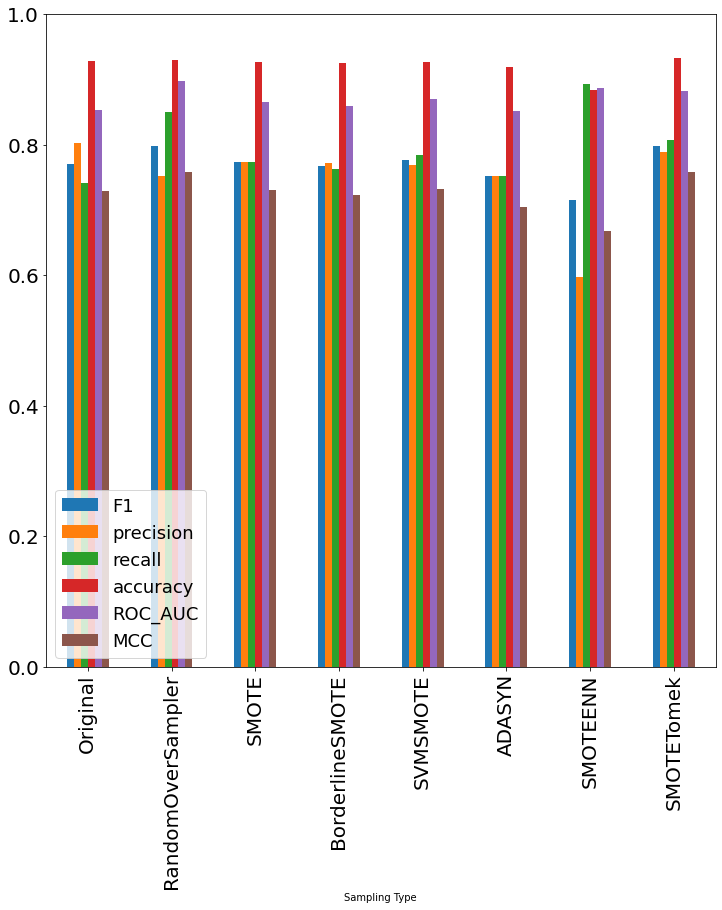

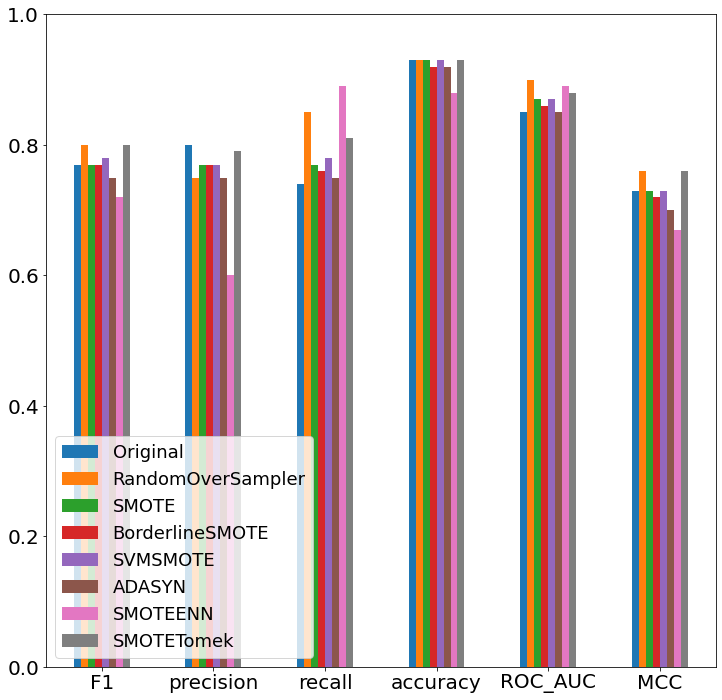

In [18]:
#print out resampling result by methods
# RandomOverSampler perform best in all of methods
resamp_methods_plot = sampling_results.plot(x = 'Sampling Type', ylim = (0,1.0), 
                                            kind = 'bar', rot = 90, stacked = False, 
                                            figsize = (12,12), fontsize = 20
                                           ).legend(loc="lower left", prop={'size': 18})
fig = resamp_methods_plot.get_figure()
fig.savefig(join(CURRENT_DIR,"picture", "resamp_methods_plot.png"))


#print out resampling result by metrics
resamp_metrics = sampling_results.transpose().iloc[:-1]
resamp_metrics.rename(columns = resamp_metrics.iloc[0],inplace=True)
resamp_metrics = resamp_metrics.iloc[1:].astype('float').round(2)
resamp_metrics_plot = resamp_metrics.plot(ylim = (0,1.0), kind = 'bar', 
                                          rot = 0 , stacked = False, 
                                          figsize = (12,12), fontsize = 20
                                         ).legend(loc="lower left", prop={'size': 18})
fig = resamp_metrics_plot.get_figure()
fig.savefig(join(CURRENT_DIR,"picture","resamp_metrics_plot.png"))

## RandomOversample perform best 
save X_train、X_test、y_train、y_test 1858，1858

In [19]:
X_train,y_train=datasets[1][1:]

In [21]:
print(len(X_train),len(y_train))

3716 3716


In [ ]:
np.save("./data/splits/X_train.npy",X_train)
np.save("./data/splits/X_test.npy",X_test)
np.save("./data/splits/y_train.npy",y_train)
np.save("./data/splits/y_test.npy",y_test)

In [ ]:
X_train=np.load("./data/splits/X_train.npy")
y_train=np.load("./data/splits/y_train.npy")
X_test=np.load("./data/splits/X_test.npy")
y_test=np.load("./data/splits/y_test.npy")

# 3、JT-VAE、oversampling method(for imblance data)

In [22]:
df['jt-vae'][1]

array([ 0.03144204, -0.37626934,  0.28288794, -0.3105216 ,  0.78598267,
       -0.28699303,  0.0759152 ,  0.17826855,  0.55597323, -0.10072717,
       -0.15150996, -0.02404155, -0.22354399,  0.25478274, -0.2974797 ,
        0.30811027,  0.10715783, -0.19580728,  0.21949965, -0.15125816,
       -0.31738758,  0.5275098 ,  0.01231663, -0.02161884, -0.1161361 ,
       -0.06273628, -0.08668878, -0.06334324], dtype=float32)

In [23]:
df['ESM1b_ts'][1]

array([ 0.01325675, -0.16644819, -0.34313837, ...,  0.38575134,
        0.03477904,  0.7142458 ], dtype=float32)

In [24]:
# X、y in dataset
def create_input_and_output_data_jtvae(df):
    X = ();
    y = (); 
    for ind in df.index:
        emb = df["ESM1b_ts"][ind]
        jtvae = df['jt-vae'][ind]               
        X = X +(np.concatenate([jtvae, emb]), )
        y = y + (df["activity"][ind], );
    return(X,y)

X, y =  create_input_and_output_data_jtvae(df )
X=np.array(X)
y=np.array(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 888)
#helper function to apply resampling
def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    if type(X) is np.ndarray and type(y) is np.ndarray:
        X_resampled,y_resampled = transformer.fit_resample(X,y)
    elif type(X) is pd.DataFrame and type(y) is pd.Series:
        X_resampled,y_resampled = transformer.fit_resample(X.values,y.values.ravel())
    else:
        print('X,y are neither ndarray nor dataframe or not the same type')
        raise
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

#transform dataset
datasets = []
datasets.append(("Original",X_train,y_train))
methods = ['RandomOverSampler','SMOTE','BorderlineSMOTE','SVMSMOTE','ADASYN','SMOTEENN','SMOTETomek']
for m in methods:
    apply_method = 'datasets.append(transform({}(random_state = 42),X_train,y_train))'.format(m)
    eval(apply_method)
    
#calculate the performance of each sampling method
resample_scores = []
for sampling_type,X,y in datasets:
    print("Training on {}".format(sampling_type))
    rf = RandomForestClassifier(n_jobs = -1, random_state = 42,n_estimators = 160)
    rf.fit(X,y)
    pred_test = rf.predict(X_test)
    pred_test_probs = rf.predict_proba(X_test)
#    probs = rf.decision_function(X_test.values) #be used with linear regression.
    fpr, tpr, thresholds = roc_curve(y_test,pred_test)
#    p,r,t = precision_recall_curve(y_test.values.ravel(),probs)
    resample_scores.append((sampling_type,
                   f1_score(y_test,pred_test),
                   precision_score(y_test,pred_test),
                   recall_score(y_test,pred_test),
                   accuracy_score(y_test,pred_test),
                   auc(fpr, tpr),
                   matthews_corrcoef(y_test,pred_test),
#                   auc(p,r,reorder=True),
                   confusion_matrix(y_test,pred_test)))

#print results
sampling_results = pd.DataFrame(resample_scores, columns=['Sampling Type','F1','precision','recall',
                                                 'accuracy','ROC_AUC','MCC','confusion_matrix'])
#sampling_results.rename(columns=str.upper,inplace = True)
sampling_results.round(2)

Transforming RandomOverSampler
Transforming SMOTE
Transforming BorderlineSMOTE
Transforming SVMSMOTE
Transforming ADASYN
Transforming SMOTEENN
Transforming SMOTETomek
Training on Original
Training on RandomOverSampler
Training on SMOTE
Training on BorderlineSMOTE
Training on SVMSMOTE
Training on ADASYN
Training on SMOTEENN
Training on SMOTETomek


,Sampling Type,F1,precision,recall,accuracy,ROC_AUC,MCC,confusion_matrix
0,Original,0.68,0.81,0.59,0.91,0.78,0.64,"[[464, 13], [38, 55]]"
1,RandomOverSampler,0.73,0.76,0.70,0.91,0.83,0.68,"[[456, 21], [28, 65]]"
2,SMOTE,0.74,0.75,0.73,0.92,0.84,0.69,"[[454, 23], [25, 68]]"
3,BorderlineSMOTE,0.73,0.76,0.70,0.92,0.83,0.68,"[[457, 20], [28, 65]]"
4,SVMSMOTE,0.73,0.74,0.72,0.91,0.84,0.68,"[[453, 24], [26, 67]]"
5,ADASYN,0.73,0.71,0.75,0.91,0.85,0.68,"[[449, 28], [23, 70]]"
6,SMOTEENN,0.56,0.42,0.84,0.79,0.81,0.48,"[[370, 107], [15, 78]]"
7,SMOTETomek,0.75,0.77,0.74,0.92,0.85,0.71,"[[456, 21], [24, 69]]"


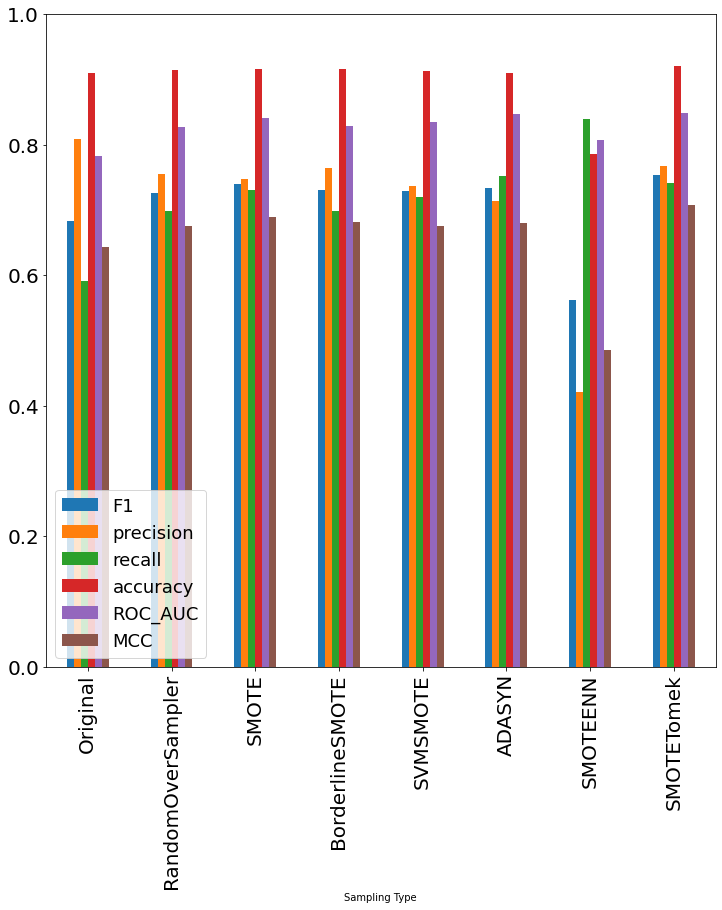

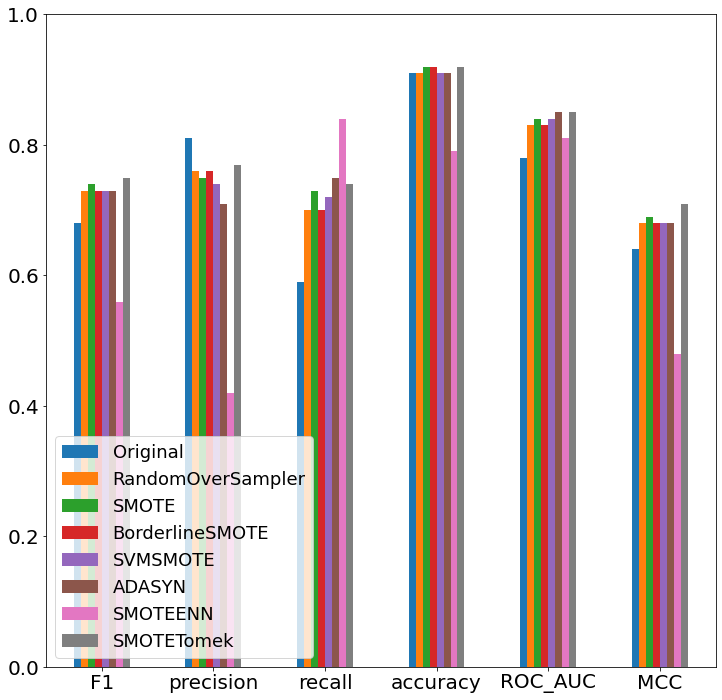

In [26]:
#print out resampling result by methods
# RandomOverSampler perform best in all of methods
resamp_methods_plot = sampling_results.plot(x = 'Sampling Type', ylim = (0,1.0), 
                                            kind = 'bar', rot = 90, stacked = False, 
                                            figsize = (12,12), fontsize = 20
                                           ).legend(loc="lower left", prop={'size': 18})
fig = resamp_methods_plot.get_figure()
fig.savefig(join(CURRENT_DIR,"picture", "resamp_methods_plot_jtvae.png"))


#print out resampling result by metrics
resamp_metrics = sampling_results.transpose().iloc[:-1]
resamp_metrics.rename(columns = resamp_metrics.iloc[0],inplace=True)
resamp_metrics = resamp_metrics.iloc[1:].astype('float').round(2)
resamp_metrics_plot = resamp_metrics.plot(ylim = (0,1.0), kind = 'bar', 
                                          rot = 0 , stacked = False, 
                                          figsize = (12,12), fontsize = 20
                                         ).legend(loc="lower left", prop={'size': 18})
fig = resamp_metrics_plot.get_figure()
fig.savefig(join(CURRENT_DIR,"picture","resamp_metrics_plot_jtvae.png"))

## SMOTETomek perform best on jtvae-dataset
save SMOTETomek train data 、test data
1847 positive,1847 negative,3692 train sample,570 test data

In [27]:
X_train,y_train=datasets[7][1:]

In [ ]:
np.save("./data/splits/jtvae/X_train.npy",X_train)
np.save("./data/splits/jtvae/X_test.npy",X_test)
np.save("./data/splits/jtvae/y_train.npy",y_train)
np.save("./data/splits/jtvae/y_test.npy",y_test)

In [ ]:
len(X_train)

## 4、MACCS Oversample

In [29]:
print(len(df['MACCS'][1]),len(df['ESM1b_ts']))

167 2847


In [30]:
# X、y in dataset
def create_input_and_output_data_maccs(df):
    X = ();
    y = ();
    
    for ind in df.index:
        emb = df["ESM1b_ts"][ind]
        maccs = np.array(list(df["MACCS"][ind])).astype(int)
                
        X = X +(np.concatenate([maccs, emb]), );
        y = y + (df["activity"][ind], );

    return(X,y)

X, y =  create_input_and_output_data_maccs(df )
X=np.array(X)
y=np.array(y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 888)
#helper function to apply resampling
def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    if type(X) is np.ndarray and type(y) is np.ndarray:
        X_resampled,y_resampled = transformer.fit_resample(X,y)
    elif type(X) is pd.DataFrame and type(y) is pd.Series:
        X_resampled,y_resampled = transformer.fit_resample(X.values,y.values.ravel())
    else:
        print('X,y are neither ndarray nor dataframe or not the same type')
        raise
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

#transform dataset
datasets = []
datasets.append(("Original",X_train,y_train))
methods = ['RandomOverSampler','SMOTE','BorderlineSMOTE','SVMSMOTE','ADASYN','SMOTEENN','SMOTETomek']
for m in methods:
    apply_method = 'datasets.append(transform({}(random_state = 42),X_train,y_train))'.format(m)
    eval(apply_method)
    
#calculate the performance of each sampling method
resample_scores = []
for sampling_type,X,y in datasets:
    print("Training on {}".format(sampling_type))
    rf = RandomForestClassifier(n_jobs = -1, random_state = 42,n_estimators = 160)
    rf.fit(X,y)
    pred_test = rf.predict(X_test)
    pred_test_probs = rf.predict_proba(X_test)
#    probs = rf.decision_function(X_test.values) #be used with linear regression.
    fpr, tpr, thresholds = roc_curve(y_test,pred_test)
#    p,r,t = precision_recall_curve(y_test.values.ravel(),probs)
    resample_scores.append((sampling_type,
                   f1_score(y_test,pred_test),
                   precision_score(y_test,pred_test),
                   recall_score(y_test,pred_test),
                   accuracy_score(y_test,pred_test),
                   auc(fpr, tpr),
                   matthews_corrcoef(y_test,pred_test),
#                   auc(p,r,reorder=True),
                   confusion_matrix(y_test,pred_test)))

#print results
sampling_results = pd.DataFrame(resample_scores, columns=['Sampling Type','F1','precision','recall',
                                                 'accuracy','ROC_AUC','MCC','confusion_matrix'])
#sampling_results.rename(columns=str.upper,inplace = True)
sampling_results.round(2)

Transforming RandomOverSampler
Transforming SMOTE
Transforming BorderlineSMOTE
Transforming SVMSMOTE
Transforming ADASYN
Transforming SMOTEENN
Transforming SMOTETomek
Training on Original
Training on RandomOverSampler
Training on SMOTE
Training on BorderlineSMOTE
Training on SVMSMOTE
Training on ADASYN
Training on SMOTEENN
Training on SMOTETomek


,Sampling Type,F1,precision,recall,accuracy,ROC_AUC,MCC,confusion_matrix
0,Original,0.71,0.69,0.72,0.90,0.83,0.65,"[[447, 30], [26, 67]]"
1,RandomOverSampler,0.70,0.63,0.80,0.89,0.85,0.64,"[[433, 44], [19, 74]]"
2,SMOTE,0.74,0.71,0.76,0.91,0.85,0.68,"[[448, 29], [22, 71]]"
3,BorderlineSMOTE,0.74,0.72,0.76,0.91,0.85,0.69,"[[450, 27], [22, 71]]"
4,SVMSMOTE,0.75,0.73,0.77,0.92,0.86,0.70,"[[451, 26], [21, 72]]"
5,ADASYN,0.74,0.71,0.77,0.91,0.86,0.69,"[[447, 30], [21, 72]]"
6,SMOTEENN,0.66,0.52,0.89,0.85,0.87,0.60,"[[400, 77], [10, 83]]"
7,SMOTETomek,0.74,0.72,0.75,0.91,0.85,0.68,"[[450, 27], [23, 70]]"


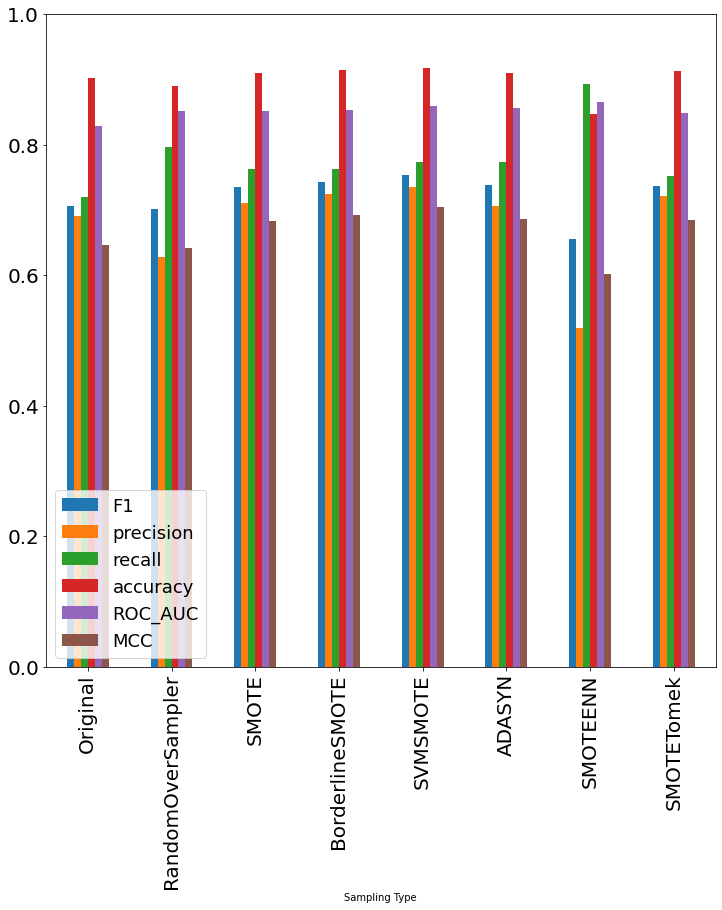

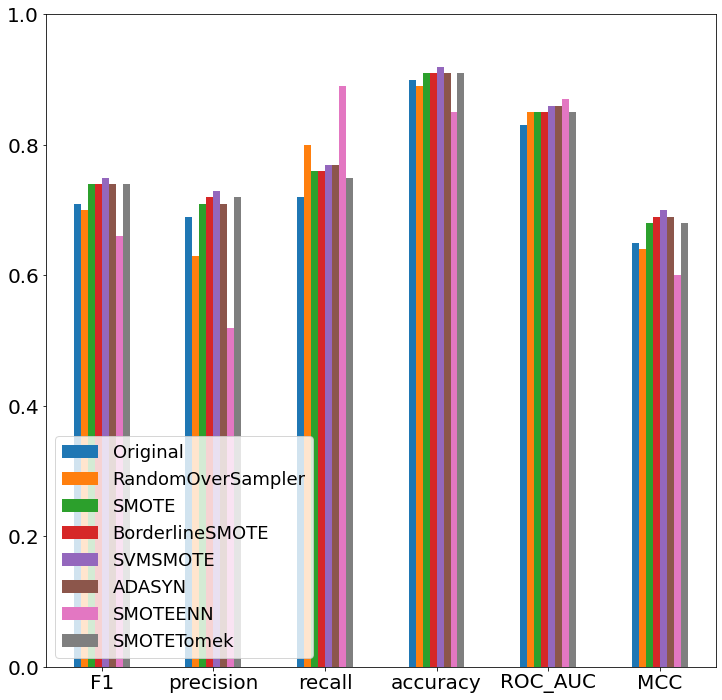

In [32]:
#print out resampling result by methods
# RandomOverSampler perform best in all of methods
resamp_methods_plot = sampling_results.plot(x = 'Sampling Type', ylim = (0,1.0), 
                                            kind = 'bar', rot = 90, stacked = False, 
                                            figsize = (12,12), fontsize = 20
                                           ).legend(loc="lower left", prop={'size': 18})
fig = resamp_methods_plot.get_figure()
fig.savefig(join(CURRENT_DIR,"picture", "resamp_methods_plot_maccs.png"))


#print out resampling result by metrics
resamp_metrics = sampling_results.transpose().iloc[:-1]
resamp_metrics.rename(columns = resamp_metrics.iloc[0],inplace=True)
resamp_metrics = resamp_metrics.iloc[1:].astype('float').round(2)
resamp_metrics_plot = resamp_metrics.plot(ylim = (0,1.0), kind = 'bar', 
                                          rot = 0 , stacked = False, 
                                          figsize = (12,12), fontsize = 20
                                         ).legend(loc="lower left", prop={'size': 18})
fig = resamp_metrics_plot.get_figure()
fig.savefig(join(CURRENT_DIR,"picture","resamp_metrics_plot_maccs.png"))

## SVMSMOTE perform best
1858条正样本和1858条负样本

In [ ]:
X_train,y_train=datasets[4][1:]

In [ ]:
X_train

In [ ]:
np.save("./data/splits/maccs/X_train.npy",X_train)
np.save("./data/splits/maccs/X_test.npy",X_test)
np.save("./data/splits/maccs/y_train.npy",y_train)
np.save("./data/splits/maccs/y_test.npy",y_test)

# Hyperparameter tuning using Grid Search

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared

#consider reducing dimensions when hyperparameter tuning if computationally too expensive

#GBDT
GBDT_param_grid = {"n_estimators" : range(50,300,50),
                   "max_depth" : [None, 5, 10, 20, 40, 160, 320],
                   "min_samples_leaf" : [1, 2, 4, 8, 16, 32, 64],
                   "learning_rate": np.arange(0.01,0.1,0.01),
                   "subsample": np.arange(0.5,0.9,0.05),
                   "max_features":['auto', 5,10,20,30]
                  }

GBDT_tuned_params = {"max_features":'auto',
                  "max_depth": None,
                  "min_samples_leaf" : 1,
                  "max_depth" : 5,
                  'learning_rate': 0.08, 
                  'n_estimators': 320,
                  "subsample": 0.85
                  }

GBDT = GradientBoostingClassifier(random_state=42).set_params(**GBDT_tuned_params)

#RF
RF_param_grid = {"n_estimators" : [160, 320, 640, 1280],
                 "max_depth" : [None, 5, 10, 20, 40, 160, 320],
                 "min_samples_leaf" : [1, 2, 4, 8, 16, 32, 64],
                 "max_features":['auto', 5,10,20,30]
                } 

RF_tuned_params = {'max_depth': None,
                   'max_features': 'auto',
                   'min_samples_leaf': 1,
                   'n_estimators': 160,
                   'n_jobs': -1,
                   'random_state': 42
                  }

RF = RandomForestClassifier(random_state=42,n_jobs=-1).set_params(**RF_tuned_params)

#LR
LR_param_grid = {'penalty': ['l1', 'l2'], #note l1 only compatible with liblinear
                 'C':[0.001,0.01,1,5,10],
                'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

LR_tuned_params = {'C': 1, 
                   'penalty': 'l2', 
                   'solver': 'lbfgs'
                  }

LR = LogisticRegression(random_state = 42).set_params(**LR_tuned_params)


#SVM
SVM_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto', 'scale'], 
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                 'probability':[True]
                 }  

SVM_tuned_params = {'C': 1000,
                    'gamma': 0.0001, 
                    'kernel': 'rbf',
                     'probability': True
                    }
SVM = SVC(random_state=42).set_params(**SVM_tuned_params)

models=['GBDT','RF','LR','SVM']
param_grids=['GBDT_param_grid','RF_param_grid','LR_param_grid','SVM_param_grid']

In [ ]:
models=[]
models.append()

In [ ]:
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, 
                             auc,roc_auc_score,roc_curve, matthews_corrcoef,precision_recall_curve,classification_report)
from sklearn.model_selection import GridSearchCV,train_test_split

#select training data from best sample method ,here is training data
X_train,y_train=datasets[1][1:]


model = eval(RF)
param_grid = RF_param_grid

#to test other metrics, uncomment below or add your own metrics
scores = [
    'accuracy'
#     'precision',
#     'roc_auc'
         ]

for score in scores:
    print("# Tuning the hyper-parameters for {}".format(score))
    gs = GridSearchCV(model, param_grid = param_grid, cv = 5, scoring='%s' % score,n_jobs=4)
    gs.fit(X_train, y_train)

    print("Best parameters set found:\n",gs.best_params_)
    print("Best score:\n", gs.best_score_) 

#detailed scores for grid_search
#pd.DataFrame(gs.cv_results_)

In [ ]:
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, 
                             auc,roc_auc_score,roc_curve, matthews_corrcoef,precision_recall_curve,classification_report)
from sklearn.model_selection import GridSearchCV,train_test_split

#select training data from best sample method ,here is training data
X_train,y_train=datasets[1][1:]


for model,param_grid in zip(models,param_grids):
    #to test other metrics, uncomment below or add your own metrics
    scores = [
        'accuracy'
#         'precision',
#         'roc_auc'
             ]
    for score in scores:
        print("# Tuning the hyper-parameters for {}".format(score))
        gs = GridSearchCV(eval(model), param_grid = eval(param_grid), cv = 5, scoring='%s' % score,n_jobs=4)
        gs.fit(X_train, y_train)

        print("Best parameters set found:\n",gs.best_params_)
        print("Best score:\n", gs.best_score_) 

    #detailed scores for grid_search
    #pd.DataFrame(gs.cv_results_)

# K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, 
                             auc,roc_auc_score,roc_curve, precision_recall_curve,classification_report)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


#K-fold validation function will take six arguments: 
#1. model, 2. train set, 3.test set, 4.# of fold, 5.shuffle boolean, 6.random_state.
def kf_cv(clf, X, y, folds = 10, shuf = True, random_state=42):
    cv = KFold(n_splits=folds, random_state=42, shuffle=shuf)
    f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])
    metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']
    print('Classifier ##{0}## will be used with {1} folds, and shuffle mode is {2}'.format(clf.__class__.__name__,
                                                                                       folds,
                                                                                       'on' if shuf else 'off')
         )
    
    for train_index, test_index in cv.split(X):
        #turn on the below code will print train_index/test_index and may help understand the details and debug.
        #print("Train Index: ", train_index, "\n")
        #print("Test Index: ", test_index)
        
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        #if sampling method is used, use this to avoid warnings: clf.fit(X_train.values, y_train.values.ravel())
        clf.fit(X_train, y_train.ravel())
        
        pred_test = clf.predict(X_test)
        pred_test_probs = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test,pred_test)
        
        f1.append(f1_score(y_test,pred_test))
        prec.append(precision_score(y_test,pred_test))
        recall.append(recall_score(y_test,pred_test))
        acc.append(accuracy_score(y_test,pred_test))
        ROC_AUC.append(roc_auc_score(y_test, pred_test_probs[:,1]))       
        conf.append(confusion_matrix(y_test,pred_test))
        
    #return a dataframe consisting five metrics and confusion matrix.
    return pd.DataFrame(zip(f1,prec,recall,acc,ROC_AUC,conf), columns = metric_cols)

Still using RandomOverSample method data for training 

In [ ]:
#setting up models using tuned hyperparameters from Grid Search.
GBDT = GradientBoostingClassifier(random_state=42).set_params(**GBDT_tuned_params)
RF = RandomForestClassifier(random_state=42).set_params(**RF_tuned_params)
LR = LogisticRegression(random_state=42).set_params(**LR_tuned_params)
SVM = SVC(random_state=42).set_params(**SVM_tuned_params)

#create dictionary to store k-fold CV results
cv_score_dict = {}
#create a dataframe to store the mean and standard error of the mean (SEM) from k-fold CV
cv_score_mean = pd.DataFrame()
cv_score_sem = pd.DataFrame()

#run k-fold CV
for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)
    cv_score_dict[model_name] = kf_cv(clf,X_train,y_train,10,True)
    cv_score_mean[model_name] = cv_score_dict[model_name].mean()[:-1]
    cv_score_sem[model_name] = cv_score_dict[model_name].sem()
    
cv_score_mean = cv_score_mean.transpose().astype(float).round(2)
cv_score_sem = cv_score_sem.transpose().round(2)

print('\n\ndetail results in dictionary "cv_score_dict" using model_name as key')
print('Performace summary in df "cv_score_mean" and "cv_score_sem"')

# check mean performance of each model.
cv_score_mean

# Plot k-fold CV

In [ ]:
#plot k-fold CV by methods
CV_plot_methods = cv_score_mean.plot(ylim = (0,1), kind = 'bar', 
                                    rot = 0 , stacked = False,
                                    yerr = cv_score_sem, capsize=4,
                                    figsize = (10,10), fontsize = 24)
plt.legend(loc=3, prop={'size': 15})
plt.title('CV_plot_methods',fontsize = 20)
plt.savefig(img_dir + "CV_plot_methods.png")


#plot k-fold CV by metrics
CV_plot_metrics = cv_score_mean.transpose().plot(kind = 'bar', ylim = (0,1),
                                                rot = 0, stacked = False,
                                                yerr = cv_score_sem.transpose(), capsize=4,
                                                figsize = (10,10), fontsize = 22)
plt.legend(loc=2, prop={'size': 20})
plt.title('CV_plot_metrics',fontsize = 20)
plt.savefig(img_dir + "CV_plot_metrics.png")

## run test  set after 5-fold cross-validation


In [ ]:
#create a dataframe to store test set performance
test_set_result = pd.DataFrame()
f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])

#evaluate the performance of the different classifiers
for model_name in ['RF','GBDT','LR','SVM']:
    clf = eval(model_name)

    clf.fit(X_train, y_train.ravel())

    pred_test = clf.predict(X_test)
    pred_test_probs = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,pred_test)

    f1.append(f1_score(y_test,pred_test))
    prec.append(precision_score(y_test,pred_test))
    recall.append(recall_score(y_test,pred_test))
    acc.append(accuracy_score(y_test,pred_test))
    ROC_AUC.append(roc_auc_score(y_test, pred_test_probs[:,1]))       
    conf.append(confusion_matrix(y_test,pred_test))
    
test_set_scores = zip(f1,prec,recall,acc,ROC_AUC,conf)   

test_set_result = pd.DataFrame(test_set_scores, 
                               columns=['F1','precision','recall',
                                        'accuracy','ROC_AUC','confusion_matrix'], 
                               index = ['RF','GBDT','LR','SVM'])
test_set_result.round(2)